<h1 align="center">If the sentiment tendencies of user reviews on Yelp are related the geographical location of the business: the case of Arizona State and California State?</h1>

<span style="color: gray;">Due to the size limit of the files allowed to be uploaded by Github, the required data files are in the compressed package. </span> 

<div style="text-align: right">
Word Count: 2017
</div>

## **1. Introduction**

This paper explores the relationship between the sentiment tendencies of user reviews on Yelp and the geographical location of the business in Arizona State and California State. And comparisons are made between Arizona State and California State, as well as within the state.
This paper mainly uses datasets provided by [Yelp](https://www.yelp.com/dataset), which contain review data and business data.   
This paper clusters businesses by their geographic location and adopts a pre-trained sentiment analysis model to analyze sentiment tendencies of user reviews on Yelp. Finally, based on the results of the previous section, this paper train a Random Forest Classifier to explore if sentiment tendencies of reviews are related to geographic location of businesse.


### 1.1 Requirements to run the file
An overview of packages used to run the analysis with brief explanation of their role.

In [1]:
# Packages for data manipulation and processing
import contextily as ctx  # used to import base map
import geopandas as gpd

# Packages for visualisation
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from shapely.geometry import Point
from sklearn import metrics

# Packages for clustering
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
from sklearn.preprocessing import MinMaxScaler, RobustScaler  # used to standardise

# Packages for sentiment analysis
from textblob import TextBlob

nltk.download("vader_lexicon")


# Packages for analysis (including Random Forest)
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier

# Used to evaluate the performance of classification models
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, validation_curve
from sklearn.preprocessing import OneHotEncoder

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


The code below is used to hide warnings so that the document becomes more clean.

In [2]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

## **2. Literature review**

In the Internet stage, customer reviews and ratings on online platforms such Yelp and TripAdvisor can be critical to businesses. According to the TripAdvisor “Influences on Diner Decision-Making” survey, 94% of US diners are influenced by online reviews(Guta, 2018). Many studies have realized the great value of these reviews and comments and have applied a variety of methods to explore these data deeply.   
About techniques and methodology, Reddy Guda's(Reddy Guda, Srivastava and Karkhanis, 2022) Multi-tasked joint BERT model effectively predicts restaurant review sentiments using the Yelp Open Datasets. Liu(Liu, 2020) made comparisons between techniques and models and found simpler models like Logistic Regression more effective than complex ones like BERT in sentiment analysis. Alexander W. Olson(Olson et al., 2021) developed novel methods for using Yelp reviews to explore collective urban representations.     
About geographical analysis, some studies focus on understanding regional differences through analysis on Yelp reviews. Hajas's study(Hajas, Gutierrez and Krishnamoorthy, 2014) examine how Yelp reviews in college towns exhibit cyclical data due to an Observer Effect and objective factors may influence reviews on businesses, despite the subjectivity of user ratings. Rahimi's team (Rahimi, Mottahedi and Liu, 2018) discovered that indicates that food and ambience choices in reviews can reflect neighborhood socioeconomic status by analyzing Yelp reviews. Longke Hu(Hu, Sun and Liu, 2014) showed that ratings are influenced by both the business's intrinsic and its neighbors' extrinsic characteristics. Some research goes beyond sentiment analysis to correlate review sentiments with business performance metrics like star ratings.  
In conclusion, the potential insights into customer satisfaction and business performance through regional sentiment analysis on Yelp reviews are critical. This study will focus on if the geographical location of the business would have relationships to sentiment of customer reviews on Yelp.

## **3. Research question**

This paper will focus on three main research questions:<br>
Q1: If there are certain spatial patterns, such as clusters of businesses on Yelp in Arizona and California? <br>
Q2: If there exist relationships between geographical locations of businesses and sentiment of user reviews on Yelp? <br>
Q3: Does the data suggest any other indicators that may influence sentiment tendencies of user reviews? <br>
More details and codes to deal with these research questions will be shown in the main body of the paper. 


## **4. Presentation of data**

### 4.1 Data description

This paper mainly applies data from [Yelp open datasets](https://www.yelp.com/dataset), which contains basic information of businesses registered on Yelp of major cities in America, such as Las Vegas, California, Washington and so on. It also includes information of user reviews like text of reviews, ratings and the time of making comments. The raw datasets are JSON files with one JSON object per line. The process of reading the raw data and converting it into a CSV file is omitted here because the data is large and it takes a long time to read.

In [3]:
# reference variables to import the relevant files
business_path = r"data/business.csv"
review_path = r"data/review.csv"
az_boundary_path = "data/shapefile/county_az.shp"
ca_boundary_path = "data/shapefile/county_ca.shp"

In [4]:
# read the files
df_business = pd.read_csv(business_path)
df_review = pd.read_csv(review_path)
az_boundary = gpd.read_file(az_boundary_path)
ca_boundary = gpd.read_file(ca_boundary_path)

To better prepare and explore the data, first look at the basic features and attributes of the raw data. This section will be seperated into two sections: business data and review data.

#### 4.1.1 Business data

In [5]:
# View the first few rows of business data
df_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [6]:
# View basic business data information
df_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       145219 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150273 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


#### 4.1.2 Review data

In [7]:
# View the first few rows of review data
df_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [8]:
# View basic review data information
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   review_id    object
 1   user_id      object
 2   business_id  object
 3   stars        int64 
 4   useful       int64 
 5   funny        int64 
 6   cool         int64 
 7   text         object
 8   date         object
dtypes: int64(4), object(5)
memory usage: 480.0+ MB


The data is relatively complete and some columns have null values.

### 4.2 Data exploration and preparation

#### 4.2.1 Business data
Briefly look at the distribution of the number of businesses in each state to check the appropriate scope of the study.

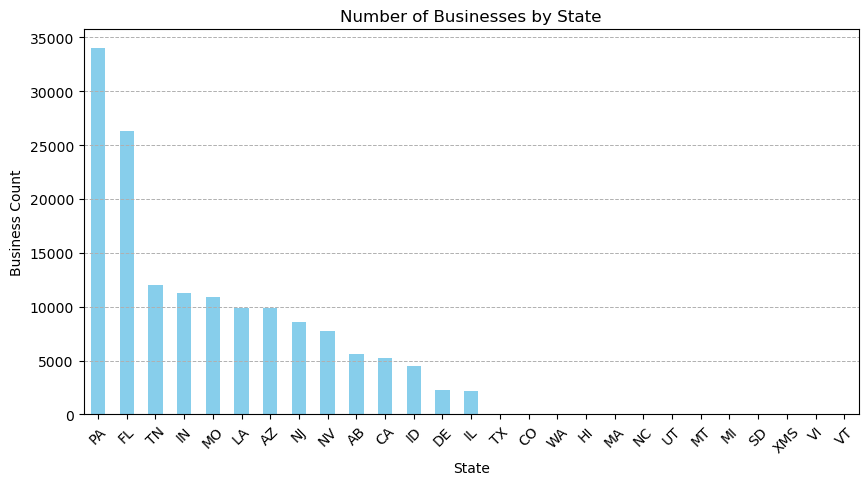

In [9]:
# Check distribution of number of businesses in different states
state_counts = df_business["state"].value_counts()

plt.figure(figsize=(10, 5))
state_counts.plot(kind="bar", color="skyblue")
plt.title("Number of Businesses by State")
plt.xlabel("State")
plt.ylabel("Business Count")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", linewidth=0.7)
plt.show()

As the graph shows, the datasets cover 27 cities in both America and Canada. In this study, California State and Arizona State in America will be used as research object, reasons are as follows:
1.  The numbers of businesses in the two states are moderate, which can ensure data adequacy and computing efficiency at the same time.
2.  The two states have significant differences in geographical features, climate and environment, which may influence their evaluative tendencies so that comparisons can be made between two states.


So the first step is to filter out business data in California State and Arizona State.

In [10]:
# To facilitate subsequent calculations, data from the two states are separately filtered
df_business_ca = df_business[df_business["state"].isin(["CA"])]
df_business_az = df_business[df_business["state"].isin(["AZ"])]

In [11]:
# Delete redundant columns
df_business_az = df_business_az.drop(
    ["name", "address", "postal_code", "is_open", "hours"], axis=1
)
df_business_ca = df_business_ca.drop(
    ["name", "address", "postal_code", "is_open", "hours"], axis=1
)

In [12]:
# Delete Nas
df_business_ca = df_business_ca.dropna()
df_business_az = df_business_az.dropna()

Now turn to second step: EDA (Exploratory Data Analysis).
The below will present the distribution of the ratings of different business, different categories of business and its mapping.

**Distribution of the ratings of different business:**

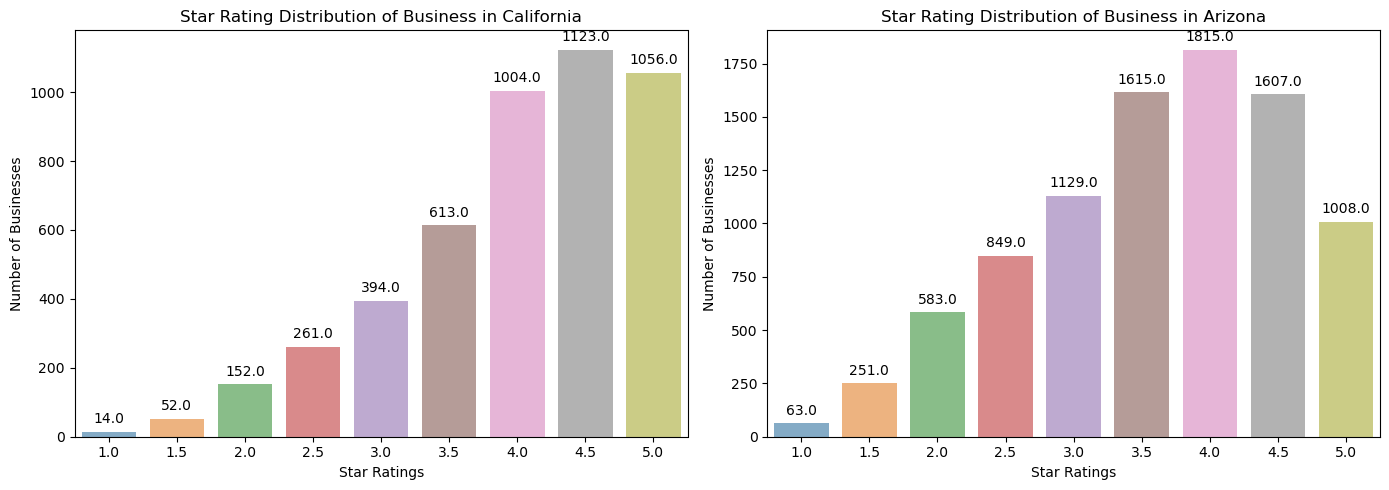

In [13]:
## the distribution of the ratings of different business ##

# Sort business rating data for California and Arizona
x_rating_ca = df_business_ca["stars"].value_counts()
x_rating_ca = x_rating_ca.sort_index()

x_rating_az = df_business_az["stars"].value_counts()
x_rating_az = x_rating_az.sort_index()

# Create Subgraphs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1行2列的子图

# California
sns.barplot(x=x_rating_ca.index, y=x_rating_ca.values, alpha=0.6, ax=axes[0])
axes[0].set_title("Star Rating Distribution of Business in California")
axes[0].set_ylabel("Number of Businesses")
axes[0].set_xlabel("Star Ratings")

# Add text labels
for p in axes[0].patches:
    axes[0].annotate(
        format(p.get_height(), ".1f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )

# Arizona
sns.barplot(x=x_rating_az.index, y=x_rating_az.values, alpha=0.6, ax=axes[1])
axes[1].set_title("Star Rating Distribution of Business in Arizona")
axes[1].set_ylabel("Number of Businesses")
axes[1].set_xlabel("Star Ratings")

# Add text labels
for p in axes[1].patches:
    axes[1].annotate(
        format(p.get_height(), ".1f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )

plt.tight_layout()
plt.show()

In California, the majorities of businesses have high ratings, with 4.5 and 5.0 stars being the most common, followed by 4.5 stars. Few businesses have low ratings (1.0 or 1.5 stars). While in Arizona, it’s a little different. The most common rating is 4.0 stars, followed closely by 3.5 and then 4.5 stars. And more low ratings are shown. It seems that overall satisfaction is higher in California than in Arizona.

**Distribution of different categories of business:**

The chart can become crowded with too many categories, so only present the top 10 categories with the highest number in each city. As shown below, the top 10 categories are similar in two states, with Restaurants, Food, and Shopping accounting for a huge proportion. Several other categories are different.

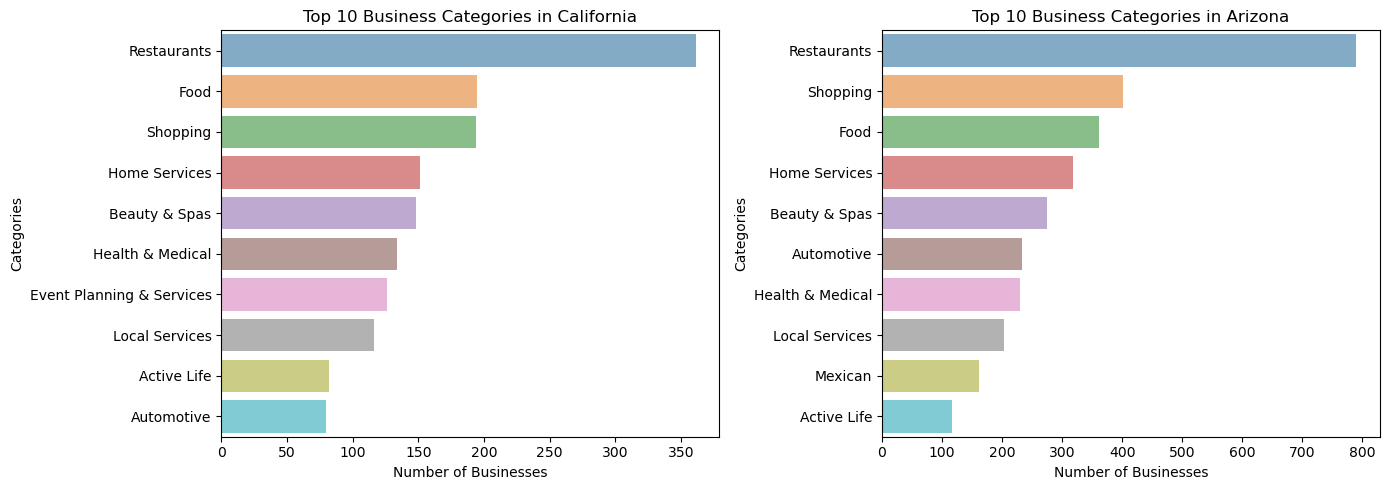

In [14]:
## the distribution of different categories of business ##

# Clean the data so that it retains only the broad categories
df_business_ca.loc[:, "categories"] = df_business_ca["categories"].apply(
    lambda x: x.split(",", 1)[0] if pd.notnull(x) else x
)
df_business_az.loc[:, "categories"] = df_business_az["categories"].apply(
    lambda x: x.split(",", 1)[0] if pd.notnull(x) else x
)

top10_categories_ca = df_business_ca["categories"].value_counts().nlargest(10)
top10_categories_az = df_business_az["categories"].value_counts().nlargest(10)

# Create Subgraphs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# California
sns.barplot(
    x=top10_categories_ca.values, y=top10_categories_ca.index, alpha=0.6, ax=axes[0]
)
axes[0].set_title("Top 10 Business Categories in California")
axes[0].set_xlabel("Number of Businesses")
axes[0].set_ylabel("Categories")

# Arizona
sns.barplot(
    x=top10_categories_az.values, y=top10_categories_az.index, alpha=0.6, ax=axes[1]
)
axes[1].set_title("Top 10 Business Categories in Arizona")
axes[1].set_xlabel("Number of Businesses")
axes[1].set_ylabel("Categories")

plt.tight_layout()
plt.show()

**Mapping:**

Now map the business in California and Arizona to see how these businesses distribute in two states spatially. In the same time, check if there are points lay out of the boundaries of the states.

In [15]:
# Turn dataframe into Geodataframe
raw_ca = (
    df_business_ca[["business_id", "latitude", "longitude"]]
    .set_index("business_id")
    .copy()
)
raw_az = (
    df_business_az[["business_id", "latitude", "longitude"]]
    .set_index("business_id")
    .copy()
)

geo_ca = [Point(xy) for xy in zip(raw_ca["longitude"], raw_ca["latitude"])]
gdf_ca = gpd.GeoDataFrame(raw_ca, geometry=geo_ca)
gdf_ca.crs = "EPSG:4326"

geo_az = [Point(xy) for xy in zip(raw_az["longitude"], raw_az["latitude"])]
gdf_az = gpd.GeoDataFrame(raw_az, geometry=geo_az)
gdf_az.crs = "EPSG:4326"

Use function plot_points_within_boundary to plot points and boundaries. In this function, different colors are use to distinguish businesses within the boundary(blue) and out of the boundary(red).

In [16]:
def plot_points_within_boundary(points_gdf, boundary_gdf):
    """
    Function to plot points and boundary, and check if all points fall within the boundary.

    Parameters:
    points_gdf (GeoDataFrame): A GeoDataFrame containing the points to check.
    boundary_gdf (GeoDataFrame): A GeoDataFrame containing the boundary to check against.

    Returns:
    None: This function only plots the points and boundary.
    """
    # Ensure that the points are in the same coordinate reference system as the boundary
    points_gdf = points_gdf.to_crs(boundary_gdf.crs)

    # Use spatial join to check if each point is within the boundary
    points_within_boundary = gpd.sjoin(points_gdf, boundary_gdf, predicate="within")

    # Find points that are outside the boundary
    points_outside_boundary = points_gdf[
        ~points_gdf.index.isin(points_within_boundary.index)
    ]

    # Initialize the plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    # Plot the boundary
    boundary_gdf.boundary.plot(ax=ax, color="black")

    # Plot points within the boundary
    if not points_within_boundary.empty:
        points_within_boundary.plot(
            ax=ax, color="blue", markersize=5, label="Points Within"
        )

    # Plot points outside the boundary
    if not points_outside_boundary.empty:
        points_outside_boundary.plot(
            ax=ax, color="red", markersize=5, label="Points Outside"
        )

    ax.legend()
    plt.show()

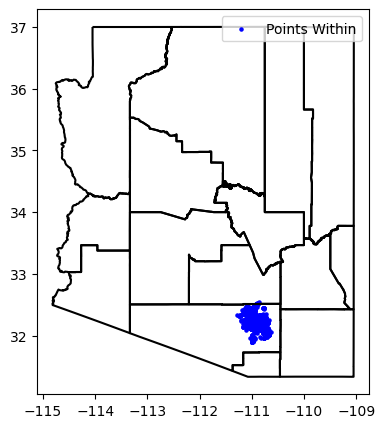

In [17]:
plot_points_within_boundary(gdf_az, az_boundary)

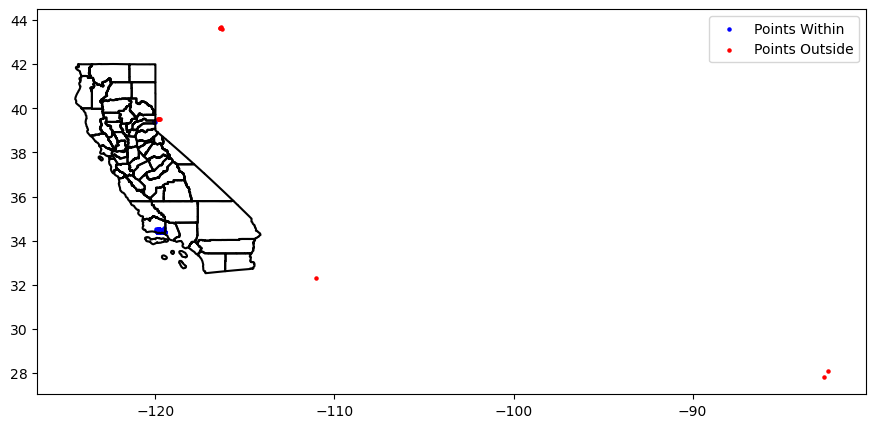

In [18]:
plot_points_within_boundary(gdf_ca, ca_boundary)

As can be seen from the maps, there's no point out of the boundary of Arizona State, but there are several points out of boundary of California State. So delete these points to clean the data.  
Notably, most businesses locate only in a small area in both Arizona and California. Check the whole business data, but for simplicity of presentation, mapping of the whole data is presented [here (example)](data/example.png ). The reasons can be that these points only reflect businesses registered on the Yelp, and in urban or densely populated areas, there’s higher commercial density while the opposite in rural areas.

In [19]:
# Ensure that both GeoDataFrames use the same coordinate reference system
ca_boundary = ca_boundary.to_crs(gdf_ca.crs)
# Use spatial join to clip points that are only within the California boundary
gdf_in_ca = gpd.sjoin(gdf_ca, ca_boundary, predicate="within")

In [20]:
# Just in case, clip points that are only within the Arizona state boundary
az_boundary = az_boundary.to_crs(gdf_az.crs)
gdf_in_az = gpd.sjoin(gdf_az, az_boundary, predicate="within")

In [21]:
# check the data clipped
gdf_in_ca.info()
gdf_in_az.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4657 entries, Pns2l4eNsfO8kk83dixA6A to BGCeUSqFOTcXcZbe6kxxbQ
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   latitude     4657 non-null   float64 
 1   longitude    4657 non-null   float64 
 2   geometry     4657 non-null   geometry
 3   index_right  4657 non-null   int64   
 4   OBJECTID     4657 non-null   float64 
 5   COUNTYNS     4657 non-null   object  
 6   GEOID        4657 non-null   object  
 7   GEOIDFQ      4657 non-null   object  
 8   NAMELSAD     4657 non-null   object  
 9   CLASSFP      4657 non-null   object  
 10  FUNCSTAT     4657 non-null   object  
 11  ALAND        4657 non-null   float64 
 12  AWATER       4657 non-null   float64 
 13  INTPTLAT     4657 non-null   object  
 14  INTPTLON     4657 non-null   object  
dtypes: float64(5), geometry(1), int64(1), object(8)
memory usage: 711.2+ KB
<class 'geopandas.geodataframe.GeoDataFrame

In [22]:
# Turn Geodataframe into dataframe
df_in_ca = pd.DataFrame(gdf_in_ca[["latitude", "longitude"]])
df_in_az = pd.DataFrame(gdf_in_az[["latitude", "longitude"]])

In [23]:
df_business_in_ca = df_business_ca[df_business_ca["business_id"].isin(df_in_ca.index)]
df_business_in_az = df_business_az[df_business_az["business_id"].isin(df_in_az.index)]

In [24]:
df_business_in_ca.info()
df_business_in_az.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4657 entries, 0 to 150303
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   4657 non-null   object 
 1   city          4657 non-null   object 
 2   state         4657 non-null   object 
 3   latitude      4657 non-null   float64
 4   longitude     4657 non-null   float64
 5   stars         4657 non-null   float64
 6   review_count  4657 non-null   int64  
 7   attributes    4657 non-null   object 
 8   categories    4657 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 363.8+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 8920 entries, 2 to 150331
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   8920 non-null   object 
 1   city          8920 non-null   object 
 2   state         8920 non-null   object 
 3   latitude      8920 non-null   float64

Now business datasets are cleaned.

### 4.2.2 Review data

First step, filter out review data in California State and Arizona State based on filtered business data. Use "business_id" to join two datasets, which is unique.

In [25]:
# Use the merge() method
df_merged_ca = pd.merge(df_review, df_business_in_ca, on="business_id", how="inner")
df_merged_az = pd.merge(df_review, df_business_in_az, on="business_id", how="inner")

In [26]:
df_merged_ca.info()
df_merged_az.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341151 entries, 0 to 341150
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   review_id     341151 non-null  object 
 1   user_id       341151 non-null  object 
 2   business_id   341151 non-null  object 
 3   stars_x       341151 non-null  int64  
 4   useful        341151 non-null  int64  
 5   funny         341151 non-null  int64  
 6   cool          341151 non-null  int64  
 7   text          341151 non-null  object 
 8   date          341151 non-null  object 
 9   city          341151 non-null  object 
 10  state         341151 non-null  object 
 11  latitude      341151 non-null  float64
 12  longitude     341151 non-null  float64
 13  stars_y       341151 non-null  float64
 14  review_count  341151 non-null  int64  
 15  attributes    341151 non-null  object 
 16  categories    341151 non-null  object 
dtypes: float64(3), int64(5), object(9)
memory usage:

Briefly look at the distribution of the reviews to check the appropriate scope of the study.

In [27]:
# convert 'date' colume to datetime object and extract the year
df_merged_ca["year"] = pd.to_datetime(df_merged_ca["date"]).dt.year
df_merged_az["year"] = pd.to_datetime(df_merged_az["date"]).dt.year

# Calculate the number of comments per year
yearly_counts_ca = df_merged_ca["year"].value_counts().sort_index()
yearly_counts_az = df_merged_az["year"].value_counts().sort_index()

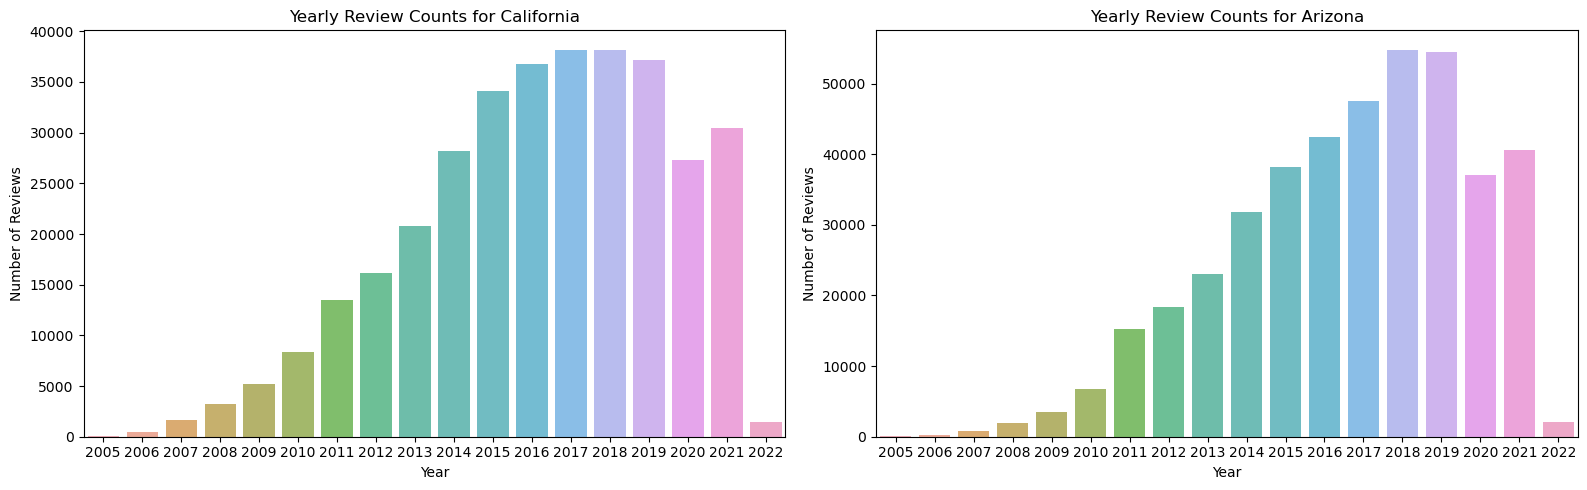

In [28]:
# Plotting
plt.figure(figsize=(16, 5))

# California
plt.subplot(1, 2, 1)
sns.barplot(x=yearly_counts_ca.index, y=yearly_counts_ca.values, alpha=0.8)
plt.title("Yearly Review Counts for California")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")

# Arizona
plt.subplot(1, 2, 2)
sns.barplot(x=yearly_counts_az.index, y=yearly_counts_az.values, alpha=0.8)
plt.title("Yearly Review Counts for Arizona")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")

plt.tight_layout()
plt.show()

The review data spans a wide range of time from 2014 to 2022, but this study will only focus on year 2020 and 2021. Reasons are as follows：
1. Comments are timely, so comments from earlier years will not be considered;
2. The number of comments has dropped significantly since 2020, which may be related to the COVID-19 epidemic, so selecting data after 2019 may be more realistic;
3. It’s possible that the COVID-19 epidemic may affect comment sentiment(Nemes and Kiss, 2021). Since this study mainly focus on the impact of geographical locations on review sentiment, selecting data after 2019 is more rigorous;
4. The year 2022 is excluded because the data amount is small. The data set only includes data from the previous few months, which may ignore the seasonal and cyclical factors of the data.

In [29]:
# Filter the data for the years 2020 and 2021
ca_time = df_merged_ca[df_merged_ca["year"].isin([2020, 2021])]
az_time = df_merged_az[df_merged_az["year"].isin([2020, 2021])]

In [30]:
# Delete redundant columns
columns_to_delete = [
    "user_id",
    "date",
]
ca_time = ca_time.drop(columns_to_delete, axis=1)
az_time = az_time.drop(columns_to_delete, axis=1)

In [31]:
# Rename columns
ca_time = ca_time.rename(
    columns={"stars_x": "star_costomer", "stars_y": "star_business"}
)
az_time = az_time.rename(
    columns={"stars_x": "star_costomer", "stars_y": "star_business"}
)

In [32]:
ca_time.info()
az_time.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57784 entries, 11 to 341147
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   review_id      57784 non-null  object 
 1   business_id    57784 non-null  object 
 2   star_costomer  57784 non-null  int64  
 3   useful         57784 non-null  int64  
 4   funny          57784 non-null  int64  
 5   cool           57784 non-null  int64  
 6   text           57784 non-null  object 
 7   city           57784 non-null  object 
 8   state          57784 non-null  object 
 9   latitude       57784 non-null  float64
 10  longitude      57784 non-null  float64
 11  star_business  57784 non-null  float64
 12  review_count   57784 non-null  int64  
 13  attributes     57784 non-null  object 
 14  categories     57784 non-null  object 
 15  year           57784 non-null  int32  
dtypes: float64(3), int32(1), int64(5), object(7)
memory usage: 7.3+ MB
<class 'pandas.core.frame.Data

In [33]:
# Calculate the number of different stars
star_counts_ca = ca_time["star_costomer"].value_counts().sort_index()
star_counts_az = az_time["star_costomer"].value_counts().sort_index()

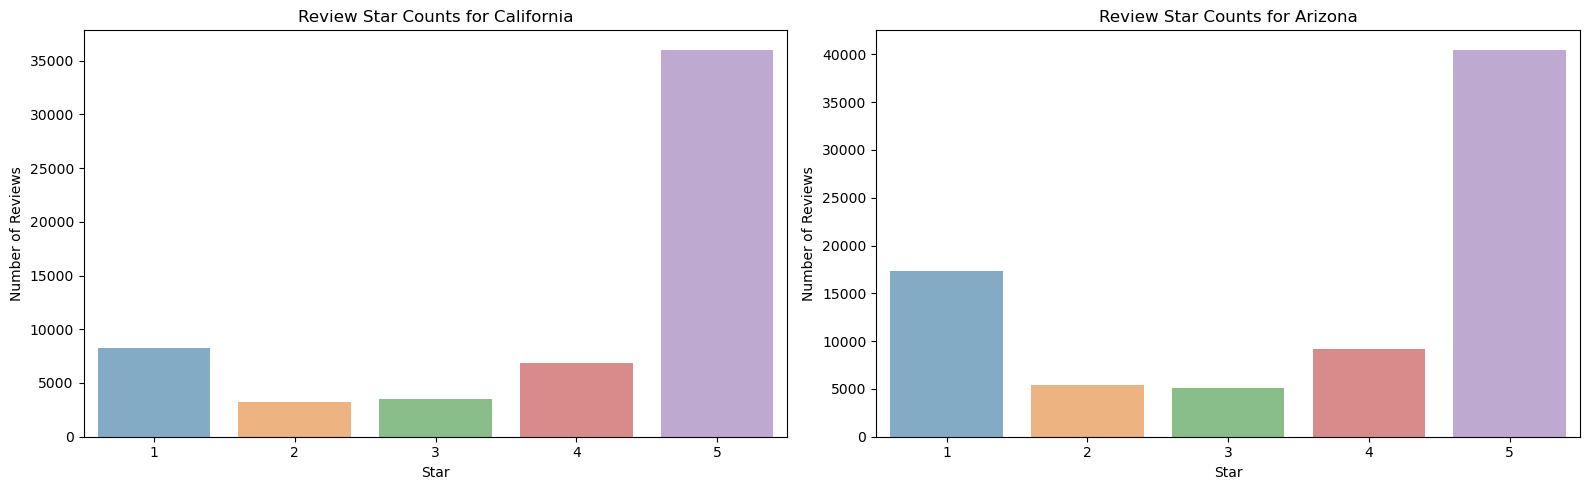

In [34]:
# Plotting
plt.figure(figsize=(16, 5))

# California
plt.subplot(1, 2, 1)
sns.barplot(x=star_counts_ca.index, y=star_counts_ca.values, alpha=0.6)
plt.title("Review Star Counts for California")
plt.xlabel("Star")
plt.ylabel("Number of Reviews")

# Arizona
plt.subplot(1, 2, 2)
sns.barplot(x=star_counts_az.index, y=star_counts_az.values, alpha=0.6)
plt.title("Review Star Counts for Arizona")
plt.xlabel("Star")
plt.ylabel("Number of Reviews")

plt.tight_layout()
plt.show()

The two charts show a similar trend, with most 5-star ratings followed by 1-star ratings, and 2, 3 and 4-star ratings are fewer. And the review chart shows a different trend compared with the business chart, indicating that customers are more likely to give a perfect score or another extreme when leaving reviews.

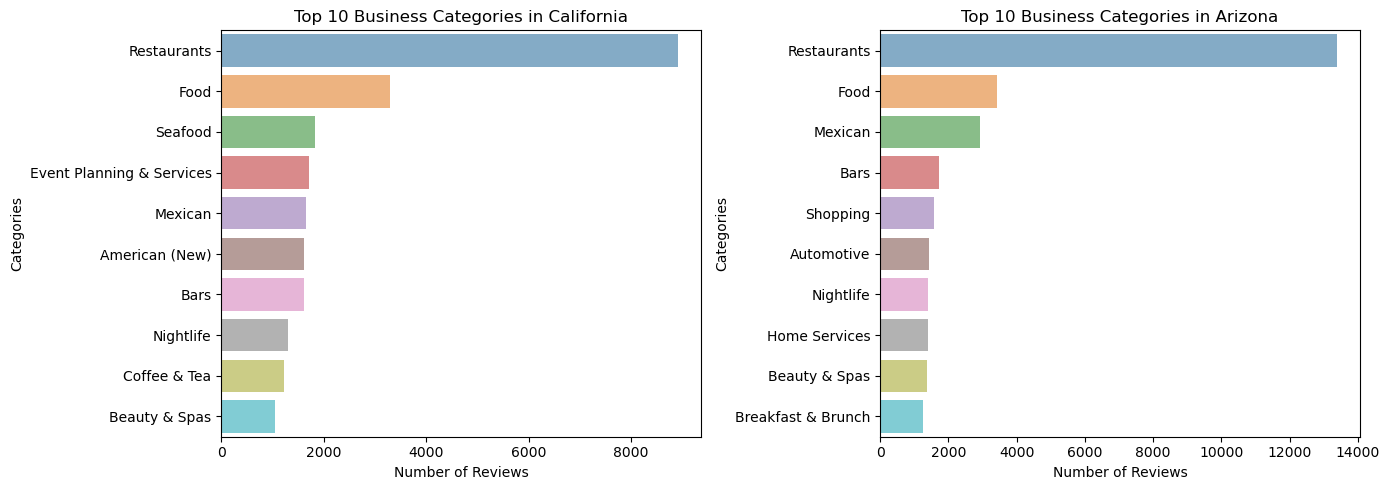

In [35]:
top10_review_ca = ca_time["categories"].value_counts().nlargest(10)
top10_review_az = az_time["categories"].value_counts().nlargest(10)

# Create Subgraphs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# California
sns.barplot(x=top10_review_ca.values, y=top10_review_ca.index, alpha=0.6, ax=axes[0])
axes[0].set_title("Top 10 Business Categories in California")
axes[0].set_xlabel("Number of Reviews")
axes[0].set_ylabel("Categories")

# Arizona
sns.barplot(x=top10_review_az.values, y=top10_review_az.index, alpha=0.6, ax=axes[1])
axes[1].set_title("Top 10 Business Categories in Arizona")
axes[1].set_xlabel("Number of Reviews")
axes[1].set_ylabel("Categories")

plt.tight_layout()
plt.show()

Similar with the top10 categories of businesses, the restaurant and food categories dominate in both states. The remaining categories are different, indicating different preference of business in Arizona and California. Additionally, the presence of categories like "Mexican" in both charts could reflect the popularity of this cuisine in the Southwestern United States.

## **5. Methodology**

This paper mainly adopts three methods:
1. **K-Means Clustering:** K-Means clustering breaks down a data set into groups, based on proximity of points within a multidimensional space(Krishna and Narasimha Murty, 1999). It’s suitable for lower dimensional and large datasets and datasets regularly shaped and convex, which is consistent with this study.
2. **Sentiment Analysis:** It’s a field of Natural Language Processing (NLP) that involves the computational study of people's opinions, sentiments, attitudes, and emotions expressed in written language(Medhat, Hassan and Korashy, 2014). In this study, considering that this is unlabeled data and the data volume is large, with more than 130,000 pieces of data, a pre-trained sentiment analysis model such as TextBlob(Loria, no date) or VADER(Hutto and Gilbert, 2014) will be used, which are both suitable for social media content.
3. **Random Forest:** It’s an ensemble learning method. It operates by constructing a multitude of decision trees during training and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees(Biau and Scornet, 2016). Random Forest can evaluate the importance of individual features during tree construction, which is very helpful in understanding the key drivers in the data, so it’s suitable for this study. And since target variable of this study is categorical, Random Forest Classifier is appropriate.

## **6. Analysis and Results**

In this section, the analysis steps will be presented in order, including Clustering, Sentiment Analysis and Random Forest.

### 6.1 Cluster analysis

Use function mapping_clusters to map clusters by labels.

In [36]:
# A function for mapping the clustering results:


def mapping_clusters(df, labels, size):
    df["cluster"] = labels

    # Ensure the DataFrame is a GeoDataFrame and has the correct coordinate system
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    gdf.crs = "EPSG:4326"  # WGS84 latitude-longitude projection

    # Create the plot
    ax = gdf.plot(
        column="cluster",
        categorical=True,
        legend=True,
        figsize=size,
        cmap="Paired",
        alpha=0.6,
        markersize=10,
    )

    # Add a base map
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string())

    ax.set_aspect("equal")

    # Set the map bounds
    ax.set_xlim(gdf.total_bounds[0], gdf.total_bounds[2])
    ax.set_ylim(gdf.total_bounds[1], gdf.total_bounds[3])

#### 6.1.1 K-Means

This study tried both DBSCAN and K-Means and compared their performance, but found that K-Means performed far better than DBSCAN, so K-Means was chosen. Considering the simplicity of the report, the DBSCAN part is not shown here.

In [37]:
# Turn Geodataframe into dataframe
df_in_ca = pd.DataFrame(gdf_in_ca[["latitude", "longitude"]])
df_in_az = pd.DataFrame(gdf_in_az[["latitude", "longitude"]])

In [38]:
# Standardisation
scaler = MinMaxScaler()

normed_az = df_in_az.copy()
for c in df_in_az.columns.values:
    normed_az[c] = scaler.fit_transform(df_in_az[c].values.reshape(-1, 1))
    print(
        "The range of {} is [{}, {}]".format(c, normed_az[c].min(), normed_az[c].max())
    )
normed_az.head()

normed_ca = df_in_ca.copy()
for c in df_in_ca.columns.values:
    normed_ca[c] = scaler.fit_transform(df_in_ca[c].values.reshape(-1, 1))
    print(
        "The range of {} is [{}, {}]".format(c, normed_ca[c].min(), normed_ca[c].max())
    )
normed_ca.head()

The range of latitude is [0.0, 1.0]
The range of longitude is [0.0, 1.0]
The range of latitude is [0.0, 1.0]
The range of longitude is [0.0, 1.0]


,latitude,longitude
business_id,,
Pns2l4eNsfO8kk83dixA6A,0.009681,0.610542
noByYNtDLQAra9ccqxdfDw,0.008389,0.627616
IDtLPgUrqorrpqSLdfMhZQ,0.007237,0.643181
nUqrF-h9S7myCcvNDecOvw,0.008271,0.664871
bYjnX_J1bHZob10DoSFkqQ,0.008414,0.611253


In [39]:
# calculate SSE for a range of number of cluster
def plot_SSE(df):
    list_SSE = []
    min_k = 1
    max_k = 10
    range_k = range(min_k, max_k + 1)
    for i in range_k:
        km = KMeans(
            n_clusters=i,
            init="random",
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0,
        )
        km.fit(df)
        # inertia is a concept from physics. Roughly it means SSE of clustering.
        list_SSE.append(km.inertia_)

    # plot
    plt.plot(range_k, list_SSE, marker="o")
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.show()

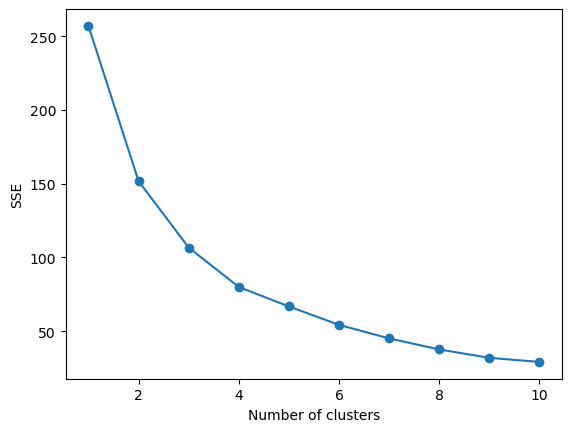

In [40]:
plot_SSE(normed_az)

This figure shows a graph of the Elbow Method for determining the optimal number of clusters, which can identify the value of k where the distortion begins to decrease most rapidly. As shown above, the elbow point may be at the location of 4 or 5 clusters. 

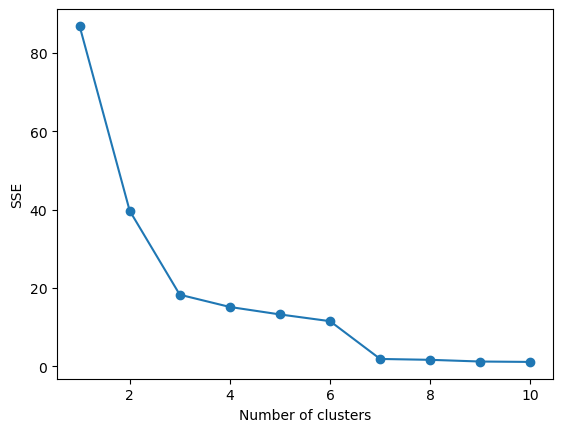

In [41]:
plot_SSE(normed_ca)

As shown above, the curve has an obvious elbow point when k is 3, after which the SSE decreases slowly. Another smaller inflection point appears to occur at cluster 6, after which the decline in SSE becomes almost flat. 

#### 6.1.2 Visualization of clusters

In [42]:
k_cluster_az = 5
random_seed = 1
kmeans_method_az = KMeans(n_clusters=k_cluster_az, random_state=random_seed)
kmeans_method_az.fit(normed_az)

KMeans(n_clusters=5, random_state=1)

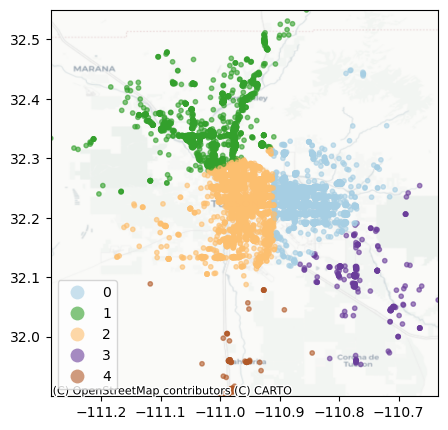

In [43]:
mapping_clusters(df_in_az, kmeans_method_az.labels_, (5, 14));

In [44]:
pd.Series(kmeans_method_az.labels_).value_counts()

2    3862
0    2776
1    1897
3     254
4     131
Name: count, dtype: int64

In [45]:
metrics.silhouette_score(normed_az, kmeans_method_az.labels_)
# The value range of the silhouette coefficient is [-1, 1]. Values close to 1 indicate that samples are tightly clustered within their own cluster and far away from other clusters.
# A silhouette coefficient of 0.43 indicates moderate closeness within clusters and moderate separation between clusters.

0.43871073266070953

In [46]:
metrics.davies_bouldin_score(normed_az, kmeans_method_az.labels_)
# The lower the value of Davies-Bouldin index, the better the clustering effect.
# A value of 0.65 indicates that the clustering quality is moderate.

0.6554804345700335

Combining elbow plot and Silhouette Score, Davies-Bouldin Score, which are both measures of clustering performance, determine that k=5. Visualization of clusters in Arizona are shown above.

In [47]:
k_cluster_ca = 3
kmeans_method_ca = KMeans(n_clusters=k_cluster_ca, random_state=random_seed)
kmeans_method_ca.fit(normed_ca)

KMeans(n_clusters=3, random_state=1)

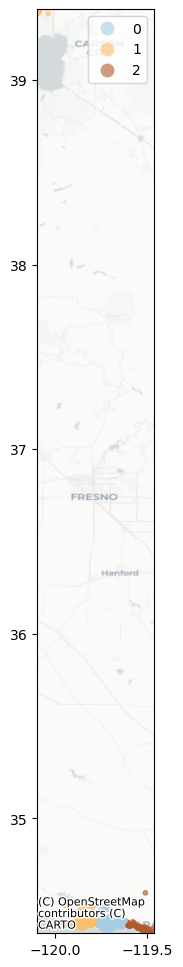

In [48]:
mapping_clusters(df_in_ca, kmeans_method_ca.labels_, (5, 12));

In [49]:
pd.Series(kmeans_method_ca.labels_).value_counts()

0    3273
1    1067
2     317
Name: count, dtype: int64

In [50]:
metrics.silhouette_score(normed_ca, kmeans_method_ca.labels_)
# A silhouette coefficient of 0.76 indicates that the clustering effect is good

0.7579940633127481

In [51]:
metrics.davies_bouldin_score(normed_ca, kmeans_method_ca.labels_)
# The lowest score on the Davidson-Boldin index is 0, which indicates ideal cluster separation.
# A score close to 0 indicates high quality clustering.

0.31601240845181633

Combining elbow plot and Silhouette Score, Davies-Bouldin Score, which are both measures of clustering performance, determine that k=3. Visualization of clusters in Arizona are shown above.

### 6.2 Sentiment analysis

To improve the accuracy of sentiment analysis, this study will randomly sample from the review data and manually label the sampled data to classify review sentiment (positive, neutral and negative). Then TextBlob and VADER were used to perform sentiment analysis on the sampled data, and the results were compared with manual labels. Finally, the model with better performance was selected to perform sentiment analysis on other data.

#### 6.2.1 Sample from two datasets and manual labelling

In [52]:
# Select 0.1% randomly from each of the two data sets as sample data.
sample_size_ca = 58
sampled_ca = ca_time.sample(n=sample_size_ca, random_state=42)

sample_size_az = 78
sampled_az = az_time.sample(n=sample_size_az, random_state=42)

In [53]:
# Manually label review data and read the labelled data
sampled_ca = pd.read_csv("data/ca_sample.csv")
sampled_az = pd.read_csv("data/az_sample.csv")

#### 6.2.2 Evaluate performance of two models and comparison

The criteria for labelling can be seen in the function get_sentiment, which is used to run two models and label reviews.

In [54]:
sia = SentimentIntensityAnalyzer()


def get_sentiment(text):
    tb = TextBlob(text)
    tb_sentiment = (
        "positive"
        if tb.sentiment.polarity > 0
        else "negative"
        if tb.sentiment.polarity < 0
        else "neutral"
    )

    vader_score = sia.polarity_scores(text)
    vader_sentiment = (
        "positive"
        if vader_score["compound"] > 0.05
        else "negative"
        if vader_score["compound"] < -0.05
        else "neutral"
    )

    return tb_sentiment, vader_sentiment


sampled_ca["tb_sentiment"], sampled_ca["vader_sentiment"] = zip(
    *sampled_ca["text"].apply(get_sentiment)
)
sampled_az["tb_sentiment"], sampled_az["vader_sentiment"] = zip(
    *sampled_az["text"].apply(get_sentiment)
)

In [55]:
# Comparison of model performance in California


# Calculate accuracy
tb_accuracy = accuracy_score(sampled_ca["label"], sampled_ca["tb_sentiment"])
vader_accuracy = accuracy_score(sampled_ca["label"], sampled_ca["vader_sentiment"])

print("TextBlob Accuracy:", tb_accuracy)
print("VADER Accuracy:", vader_accuracy)

# Output detailed classification reports
print("\nTextBlob Classification Report:")
print(
    classification_report(
        sampled_ca["label"], sampled_ca["tb_sentiment"], zero_division=0
    )
)

print("\nVADER Classification Report:")
print(
    classification_report(
        sampled_ca["label"], sampled_ca["vader_sentiment"], zero_division=0
    )
)

# accuracy_score and classification_report are both part of the scikit-learn library and are used to evaluate the performance of classification models

TextBlob Accuracy: 0.8275862068965517
VADER Accuracy: 0.9482758620689655

TextBlob Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.40      0.55        15
     neutral       0.00      0.00      0.00         0
    positive       0.84      0.98      0.90        43

    accuracy                           0.83        58
   macro avg       0.57      0.46      0.48        58
weighted avg       0.84      0.83      0.81        58


VADER Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.80      0.89        15
     neutral       0.00      0.00      0.00         0
    positive       0.96      1.00      0.98        43

    accuracy                           0.95        58
   macro avg       0.65      0.60      0.62        58
weighted avg       0.97      0.95      0.95        58



In [56]:
# Comparison of model performance in Arizona


# Calculate accuracy
tb_accuracy = accuracy_score(sampled_az["label"], sampled_az["tb_sentiment"])
vader_accuracy = accuracy_score(sampled_az["label"], sampled_az["vader_sentiment"])

print("TextBlob Accuracy:", tb_accuracy)
print("VADER Accuracy:", vader_accuracy)

# Output detailed classification reports
print("\nTextBlob Classification Report:")
print(
    classification_report(
        sampled_az["label"], sampled_az["tb_sentiment"], zero_division=0
    )
)

print("\nVADER Classification Report:")
print(
    classification_report(
        sampled_az["label"], sampled_az["vader_sentiment"], zero_division=0
    )
)

TextBlob Accuracy: 0.7692307692307693
VADER Accuracy: 0.7692307692307693

TextBlob Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.39      0.56        28
     neutral       0.00      0.00      0.00         1
    positive       0.73      1.00      0.84        49

    accuracy                           0.77        78
   macro avg       0.58      0.46      0.47        78
weighted avg       0.82      0.77      0.73        78


VADER Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.39      0.56        28
     neutral       0.00      0.00      0.00         1
    positive       0.74      1.00      0.85        49

    accuracy                           0.77        78
   macro avg       0.58      0.46      0.47        78
weighted avg       0.83      0.77      0.74        78



Overall, the precision, recall, and f1-score of the VADER model are higher than the TextBlob model in both Arizona and California, indicating that VADER performs better on this data set. Therefore, this study will choose VADER for sentiment analysis. 

#### 6.2.3 Sentiment analysis of the remaining data

In [57]:
# delete samples from dataset
ca_time_dropped = ca_time[~ca_time["business_id"].isin(sampled_ca["business_id"])]
az_time_dropped = az_time[~az_time["business_id"].isin(sampled_az["business_id"])]

In [58]:
# Although the selected data was not used to train the model and therefore would not cause data leakage
# This part of the data was deleted due to the sufficient amount of data and the consideration of rigor.
ca_sentiment = ca_time_dropped.copy()
az_sentiment = az_time_dropped.copy()

In [59]:
# Apply VADER
# Funtion sentiment_anlysis is used to apply VADER to the datasets
def sentiment_anlysis(text):
    vader_score = sia.polarity_scores(text)
    vader_sentiment = (
        "positive"
        if vader_score["compound"] > 0.05
        else "negative"
        if vader_score["compound"] < -0.05
        else "neutral"
    )

    return vader_sentiment


ca_sentiment["vader_sentiment"] = ca_sentiment["text"].apply(sentiment_anlysis)
az_sentiment["vader_sentiment"] = az_sentiment["text"].apply(sentiment_anlysis)

In [60]:
# Calculate the number of reviews with different sentment for two states
sentiment_counts_ca = ca_sentiment["vader_sentiment"].value_counts().sort_index()
sentiment_counts_az = az_sentiment["vader_sentiment"].value_counts().sort_index()

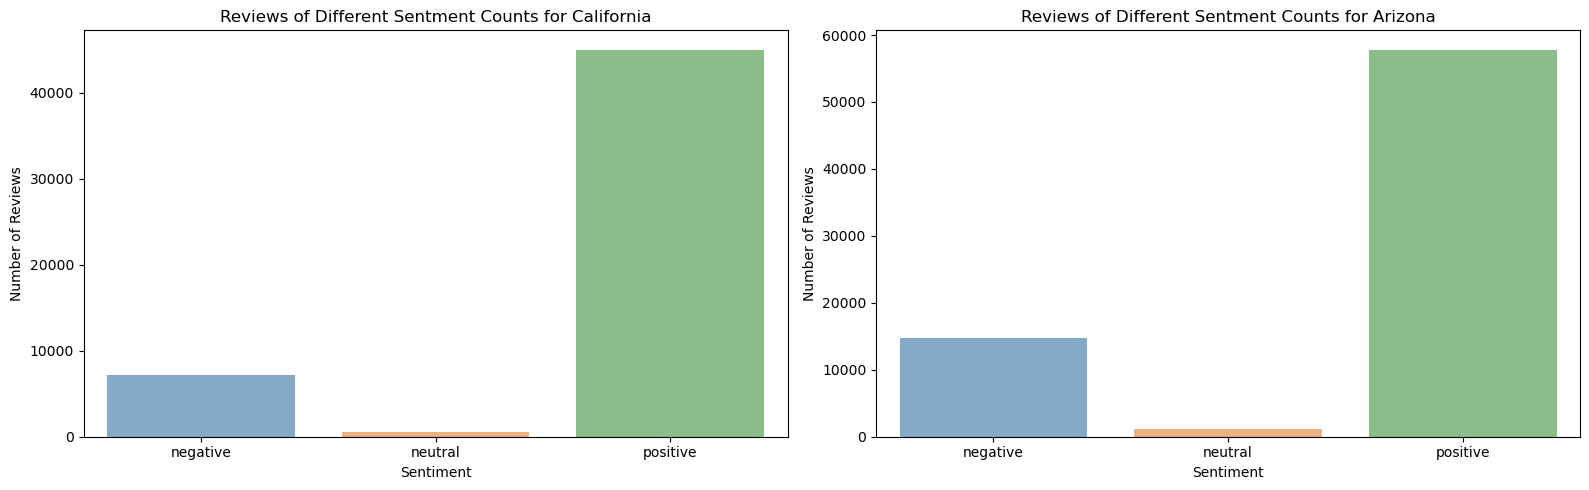

In [61]:
# Visualization

plt.figure(figsize=(16, 5))

# California
plt.subplot(1, 2, 1)
sns.barplot(x=sentiment_counts_ca.index, y=sentiment_counts_ca.values, alpha=0.6)
plt.title("Reviews of Different Sentment Counts for California")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")

# Arizona
plt.subplot(1, 2, 2)
sns.barplot(x=sentiment_counts_az.index, y=sentiment_counts_az.values, alpha=0.6)
plt.title("Reviews of Different Sentment Counts for Arizona")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")

plt.tight_layout()
plt.show()

The two charts show a similar trend, with positive reviews dominating, followed by a much smaller number of neutral reviews, and an even smaller number of negative reviews. This implies a tendency among users to post reviews when they have a positive experience. 

### 6.3 Random Forest

Based on the results of the previous sentiment analysis and spatial clustering, analyze whether there is a relationship between them. Firstly, Chi-square test is used to test whether there is a significant association between two categorical variables. Then a Random Forest Classifier is used to see the specific importance of different variables.  
And as can be seen in the heat map, the majorities of reviews are positive across all geographic clusters in two states. Certain clusters have a higher propensity for positive or negative reviews, which could be influenced by various factors like population density, the concentration of businesses, or local economic conditions.


In [62]:
# merge data
az_sentiment_with_clusters = az_sentiment.merge(
    df_in_az[["cluster"]], on="business_id", how="left"
)
ca_sentiment_with_clusters = ca_sentiment.merge(
    df_in_ca[["cluster"]], on="business_id", how="left"
)

In [63]:
contingency_table_az = pd.crosstab(
    az_sentiment_with_clusters["vader_sentiment"], az_sentiment_with_clusters["cluster"]
)
contingency_table_ca = pd.crosstab(
    ca_sentiment_with_clusters["vader_sentiment"], ca_sentiment_with_clusters["cluster"]
)

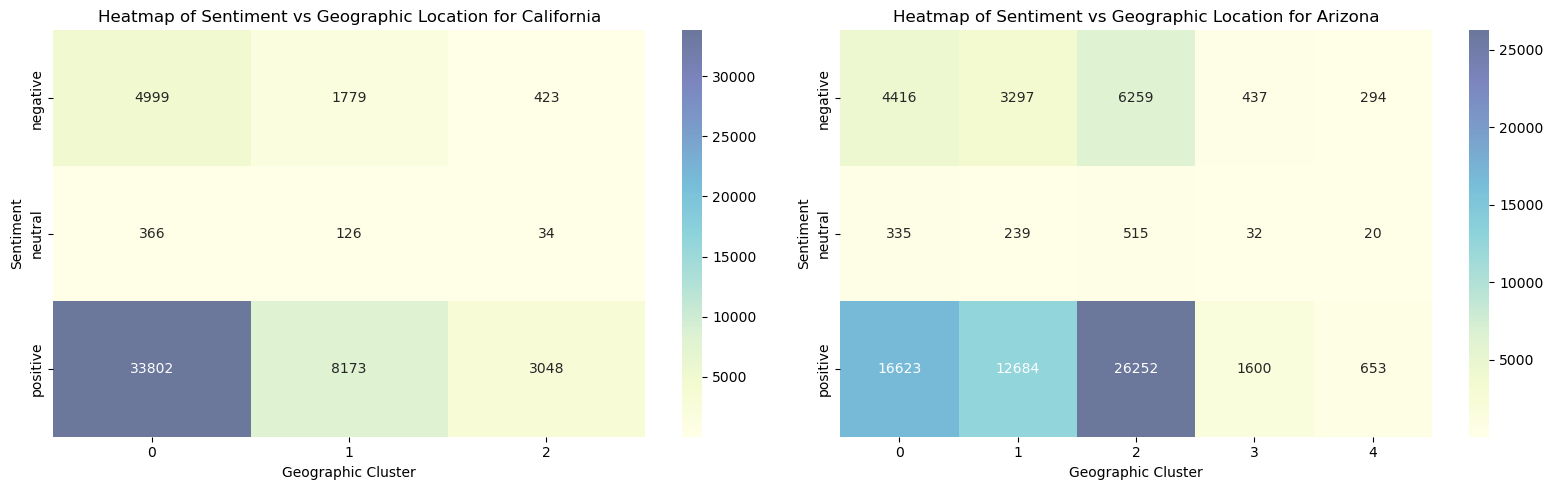

In [64]:
# Visualization
plt.figure(figsize=(16, 5))

# California
plt.subplot(1, 2, 1)
sns.heatmap(contingency_table_ca, annot=True, fmt="d", cmap="YlGnBu", alpha=0.6)
plt.title("Heatmap of Sentiment vs Geographic Location for California")
plt.xlabel("Geographic Cluster")
plt.ylabel("Sentiment")

# Arizona
plt.subplot(1, 2, 2)
sns.heatmap(contingency_table_az, annot=True, fmt="d", cmap="YlGnBu", alpha=0.6)
plt.title("Heatmap of Sentiment vs Geographic Location for Arizona")
plt.xlabel("Geographic Cluster")
plt.ylabel("Sentiment")

plt.tight_layout()
plt.show()

#### 6.3.1 Chi-Square Analysis

In [65]:
# Function Chi_Square_test is used to do Chi-Square test and print results.


def Chi_Square_test(df):
    # Contingency Table Analysis
    contingency_table = pd.crosstab(df["vader_sentiment"], df["cluster"])

    # Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # This value represents the sum of the differences between observed and expected frequencies.
    # The larger the value, the greater the difference and the stronger the correlation between the two variables.
    print("Chi-squared Test statistic:", chi2)

    # This represents the probability of observing the current chi-square statistic or a more extreme value if the null hypothesis (that the two variables are independent) is true.
    print("P-value:", p)

    # This value depends on the number of categories of variables in the study.
    print("Degrees of freedom:", dof)
    print(
        "Expected frequencies:\n",
        pd.DataFrame(
            expected, columns=contingency_table.columns, index=contingency_table.index
        ),
    )

    if p < 0.05:
        print(
            "There is sufficient evidence to reject the independence hypothesis and sentiment of reviews are correlated with geographic location."
        )
    else:
        print(
            "There is insufficient evidence to reject the independence hypothesis and sentiment of reviews and geographic location may be independent."
        )

In [66]:
Chi_Square_test(az_sentiment_with_clusters)

Chi-squared Test statistic: 100.68126354735452
P-value: 3.097948559159217e-18
Degrees of freedom: 8
Expected frequencies:
 cluster                     0             1             2            3  \
vader_sentiment                                                          
negative          4266.616732   3237.789997   6592.555637   413.007861   
neutral            331.103155    251.262898    511.603481    32.050736   
positive         16776.280113  12730.947105  25921.840882  1623.941403   

cluster                   4  
vader_sentiment              
negative         193.029774  
neutral           14.979730  
positive         758.990496  
There is sufficient evidence to reject the independence hypothesis and sentiment of reviews are correlated with geographic location.


In [67]:
Chi_Square_test(ca_sentiment_with_clusters)

Chi-squared Test statistic: 181.8614665659067
P-value: 2.9699218674130046e-38
Degrees of freedom: 4
Expected frequencies:
 cluster                     0            1            2
vader_sentiment                                        
negative          5346.759564  1375.766408   478.474028
neutral            390.556246   100.493422    34.950332
positive         33429.684190  8601.740171  2991.575640
There is sufficient evidence to reject the independence hypothesis and sentiment of reviews are correlated with geographic location.


As shown above, there’s sufficient evidence to reject the independence hypothesis and sentiment of reviews are correlated with geographic location in both cities. 

#### 6.3.2 Random Forest

In [68]:
# Function adjust_categories is used to adjust variable 'categories'
def adjust_categories(df):
    top_ten_categories = df["categories"].value_counts().nlargest(10).index
    df["categories_adjusted"] = df["categories"].apply(
        lambda x: x if x in top_ten_categories else "Other"
    )

In [69]:
adjust_categories(ca_sentiment_with_clusters)
adjust_categories(az_sentiment_with_clusters)

In [70]:
az_sentiment_with_clusters.head()

,review_id,business_id,star_costomer,useful,funny,cool,text,city,state,latitude,longitude,star_business,review_count,attributes,categories,year,vader_sentiment,cluster,categories_adjusted
0,JGvlW20ZQiqcvgrZ3Fo2_g,YjUWPpI6HXG530lwP-fb2A,4,0,0,0,"This place is set up as a buffet, it's your ty...",Tucson,AZ,32.207233,-110.980864,3.5,47,"{'RestaurantsReservations': 'True', 'BusinessP...",Restaurants,2021,positive,2,Restaurants
1,f40Gxw572dBok5dm2f80ZQ,YjUWPpI6HXG530lwP-fb2A,5,0,0,0,It was my first time eating at this restaurant...,Tucson,AZ,32.207233,-110.980864,3.5,47,"{'RestaurantsReservations': 'True', 'BusinessP...",Restaurants,2021,positive,2,Restaurants
2,EQPMIfcwLreDLZZcN_dVOQ,YjUWPpI6HXG530lwP-fb2A,5,0,0,0,GREAT service!! The waitress and owner were su...,Tucson,AZ,32.207233,-110.980864,3.5,47,"{'RestaurantsReservations': 'True', 'BusinessP...",Restaurants,2021,positive,2,Restaurants
3,fLQHEoAfAFBr_kByUWbGcw,YjUWPpI6HXG530lwP-fb2A,1,0,0,0,Buffet was all dried up old looking no selecti...,Tucson,AZ,32.207233,-110.980864,3.5,47,"{'RestaurantsReservations': 'True', 'BusinessP...",Restaurants,2021,negative,2,Restaurants
4,m-4K5J1v34dF-3zERltlyg,YjUWPpI6HXG530lwP-fb2A,5,0,0,0,My family and are actors and we were in town s...,Tucson,AZ,32.207233,-110.980864,3.5,47,"{'RestaurantsReservations': 'True', 'BusinessP...",Restaurants,2020,positive,2,Restaurants


In [71]:
# OneHot encoding


# Function Onehot is used to do OneHot encoding for categorical variables
def Onehot(df, features_to_encode, target, numerical_features):
    # Initialise the encoder, set drop='first' to remove the first category of each dummy variable
    encoder = OneHotEncoder(sparse=False, drop="first")

    encoded_features = []
    for feature in features_to_encode:
        encoded_feat = encoder.fit_transform(df[[feature]])
        columns = [f"{feature}_{c}" for c in encoder.categories_[0][1:]]
        encoded_feat_df = pd.DataFrame(encoded_feat, columns=columns, index=df.index)
        encoded_features.append(encoded_feat_df)

    # Combine features of OneHot encoding with numerical features
    encoded_df = pd.concat([df[numerical_features]] + encoded_features, axis=1)

    return encoded_df, df[target]

**Arizona:**

In [72]:
X_encoded_az, y_az = Onehot(
    az_sentiment_with_clusters,
    features_to_encode=["cluster", "categories_adjusted"],
    target="vader_sentiment",
    numerical_features=["latitude", "longitude", "star_business", "review_count"],
)

In [73]:
# Split the train and test datasets
X_train_az, X_test_az, y_train_az, y_test_az = train_test_split(
    X_encoded_az, y_az, test_size=0.2, random_state=42
)

In [74]:
# Values of max_depth and min_samples_split
hyperparameters = {
    "max_depth": [10, 20, 30, 40, 50],
    "min_samples_split": [2, 4, 6, 8, 10],
}

randomState_dt = 10000
rf_az = RandomForestClassifier(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf_az = GridSearchCV(rf_az, hyperparameters)

clf_az.fit(X_train_az, y_train_az)

# we can query the best parameter value and its accuracy score
print("The best parameter value is: ")
print(clf_az.best_params_)
print("The best score is: ")
print(clf_az.best_score_)

The best parameter value is: 
{'max_depth': 10, 'min_samples_split': 8}
The best score is: 
0.7951937707183554


In [75]:
rf_final_az = RandomForestClassifier(
    max_depth=clf_az.best_params_["max_depth"],
    min_samples_split=clf_az.best_params_["min_samples_split"],
    random_state=randomState_dt,
)
rf_final_az.fit(X_train_az, y_train_az)

RandomForestClassifier(max_depth=10, min_samples_split=8, random_state=10000)

In [76]:
# The R^2 score on the training data is approximately 0.8016, suggesting that the model explains about 80.16% of the variance within the training dataset.
print("R2 on the training data:")
print(rf_final_az.score(X=X_train_az, y=y_train_az))

# The R^2 score on the testing data is approximately 0.7933, indicating that the model explains about 79.33% of the variance within the test dataset.
print("R2 on the testing data:")
print(rf_final_az.score(X=X_test_az, y=y_test_az))

R2 on the training data:
0.8016258230941552
R2 on the testing data:
0.7933070866141733


These are fairly high R^2 scores, suggesting that the model has a good fit to both the training and testing data. And there is no evidence of overfitting as the training and test scores are very close.

In [77]:
# Importance of feature
importances_az = rf_final_az.feature_importances_

feature_names_az = X_encoded_az.columns
feature_importances_az = pd.DataFrame(
    importances_az, index=feature_names_az, columns=["Importance_az"]
).sort_values("Importance_az", ascending=False)
print(feature_importances_az)

                                   Importance_az
star_business                           0.704364
review_count                            0.100468
latitude                                0.077106
longitude                               0.070853
cluster_2                               0.005674
categories_adjusted_Restaurants         0.004943
categories_adjusted_Other               0.004774
categories_adjusted_Shopping            0.003903
categories_adjusted_Mexican             0.003304
categories_adjusted_Food                0.003124
categories_adjusted_Home Services       0.003117
cluster_1                               0.003067
categories_adjusted_Sandwiches          0.003014
categories_adjusted_Beauty & Spas       0.002969
categories_adjusted_Nightlife           0.002830
cluster_3                               0.002342
categories_adjusted_Bars                0.002102
cluster_4                               0.002046


The results point towards a combination of business type, geographic location, and overall business rating as influential factors on the sentiment of user reviews in Arizona. And the star rating of a business has the highest importance, while the type of business may affect the sentiment of the reviews very slightly.

**California:**

In [78]:
X_encoded_ca, y_ca = Onehot(
    ca_sentiment_with_clusters,
    features_to_encode=["cluster", "categories_adjusted"],
    target="vader_sentiment",
    numerical_features=["latitude", "longitude", "star_business", "review_count"],
)
# Split the train and test datasets
X_train_ca, X_test_ca, y_train_ca, y_test_ca = train_test_split(
    X_encoded_ca, y_ca, test_size=0.2, random_state=42
)

In [79]:
rf_ca = RandomForestClassifier(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf_ca = GridSearchCV(rf_ca, hyperparameters)

clf_ca.fit(X_train_ca, y_train_ca)

# we can query the best parameter value and its accuracy score
print("The best parameter value is: ")
print(clf_ca.best_params_)
print("The best score is: ")
print(clf_ca.best_score_)

The best parameter value is: 
{'max_depth': 10, 'min_samples_split': 10}
The best score is: 
0.8563744075829384


In [80]:
rf_final_ca = RandomForestClassifier(
    max_depth=clf_ca.best_params_["max_depth"],
    min_samples_split=clf_ca.best_params_["min_samples_split"],
    random_state=randomState_dt,
)
rf_final_ca.fit(X_train_ca, y_train_ca)

RandomForestClassifier(max_depth=10, min_samples_split=10, random_state=10000)

In [81]:
# The R^2 score on the training data is approximately 0.8605, suggesting that the model explains about 86.05% of the variance within the training dataset.
print("R2 on the training data:")
print(rf_final_ca.score(X=X_train_ca, y=y_train_ca))

# # The R^2 score on the testing data is approximately 0.8514, suggesting that the model explains about 85.14% of the variance within the training dataset.
print("R2 on the testing data:")
print(rf_final_ca.score(X=X_test_ca, y=y_test_ca))

R2 on the training data:
0.8604739336492891
R2 on the testing data:
0.8513744075829384


The conclusion is similar with the model of Arizona that the model has a good fit to both the training and testing data. And there is no evidence of overfitting as the training and test scores are very close.

In [82]:
# Importance of feature
importances_ca = rf_final_ca.feature_importances_

feature_names_ca = X_encoded_ca.columns
feature_importances_ca = pd.DataFrame(
    importances_ca, index=feature_names_ca, columns=["Importance_ca"]
).sort_values("Importance_ca", ascending=False)
print(feature_importances_ca)

                                               Importance_ca
star_business                                       0.616608
longitude                                           0.112703
latitude                                            0.109349
review_count                                        0.109323
cluster_1                                           0.009484
categories_adjusted_Other                           0.007921
categories_adjusted_Restaurants                     0.006603
categories_adjusted_Event Planning & Services       0.006040
categories_adjusted_Food                            0.004449
categories_adjusted_Nightlife                       0.003688
categories_adjusted_Mexican                         0.003302
categories_adjusted_Coffee & Tea                    0.002573
categories_adjusted_Beauty & Spas                   0.002336
cluster_2                                           0.002291
categories_adjusted_American (Traditional)          0.001840
categories_adjusted_Bars

Just like in Arizona, the average star rating of a business is the most important feature, which suggests a strong relationship between a business's rating and the sentiment of its reviews. Geographic coordinates are important but less so compared to the average star rating, indicating that while location is a factor, it's not as strong as the business's star rating.

**Visualization:**

In [83]:
# Arizona
importances_az = rf_final_az.feature_importances_
feature_names_az = X_encoded_az.columns
feature_importances_az = pd.DataFrame(
    importances_az, index=feature_names_az, columns=["Importance_az"]
).sort_values("Importance_az", ascending=False)

# California
importances_ca = rf_final_ca.feature_importances_
feature_names_ca = X_encoded_ca.columns
feature_importances_ca = pd.DataFrame(
    importances_ca, index=feature_names_ca, columns=["Importance_ca"]
).sort_values("Importance_ca", ascending=False)

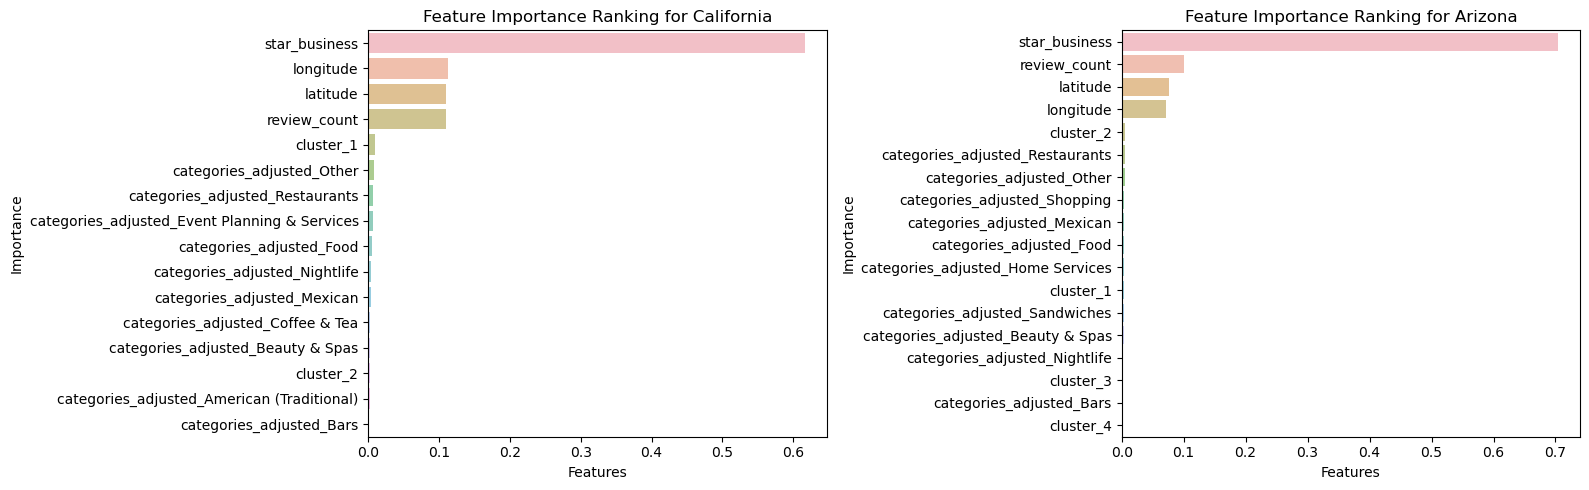

In [84]:
plt.figure(figsize=(16, 5))

# California
plt.subplot(1, 2, 1)
sns.barplot(
    x=feature_importances_ca["Importance_ca"], y=feature_importances_ca.index, alpha=0.6
)
plt.title("Feature Importance Ranking for California")
plt.xlabel("Features")
plt.ylabel("Importance")

# Arizona
plt.subplot(1, 2, 2)
sns.barplot(
    x=feature_importances_az["Importance_az"], y=feature_importances_az.index, alpha=0.6
)
plt.title("Feature Importance Ranking for Arizona")
plt.xlabel("Features")
plt.ylabel("Importance")

plt.tight_layout()
plt.show()

Comparing California and Arizona, similarities seem exist in the significance of star ratings and review count. Also, categories of businesses are both insignificant despite different ranks in two states. However, there may be differences in how geographic location rank between the two states, indicating that there could be region-specific factors that influence review sentiments in each state.   
Notably, original coordinates (latitude and longitude) have higher feature importance than clustering, probably because coordinates provide better geographical information than clustering. Some specific geographical locations may have a direct impact on emotional tendencies due to specific regional characteristics (such as tourist hot spots, business districts, etc.), and these details may not be reflected in clustering. Or the distribution of businesses may be spatially uneven, leading to an increase in the importance of the original coordinates. 


## **7. Conclusion and Discussion**

Now back to the three research questions:<br>
Q1: There are spatial clusters of businesses register on Yelp in Arizona and California. In Arizona there are 5 clusters and in California there are 3 clusters. <br>
Q2: There exist certain relationships between geographical locations of businesses and sentiment of user reviews on Yelp, but the relationships may be weak. And it seems that geographical locations affect the sentiment of user reviews both within a state and potentially between states. <br>
Q3: Features such as star ratings and review count of businesses may have relationships with sentiment tendencies of user reviews, and they are even more significant than geographical locations. <br>

In conclusion, three research questions are all answered. However, due to time and space constraints, it is still unclear whether the geographical locations of businesses directly affect the emotional tendency of reviews and the specific relationship between them. Also, because only two states are analyzed, conclusions within a state and between states may be random.


## Reference

Biau, G. and Scornet, E. (2016). ‘A random forest guided tour’. TEST, 25 (2), pp. 197–227. doi: 10.1007/s11749-016-0481-7.

Guta, M. (2018). 94% of Diners Will Choose Your Restaurant Based on Online Reviews. Small Business Trends. Available at: https://smallbiztrends.com/how-diners-choose-restaurants/ (Accessed: 17 April 2024).
Hajas, P., Gutierrez, L. and Krishnamoorthy, M. S. (2014). ‘Analysis of Yelp Reviews’. arXiv. doi: 10.48550/arXiv.1407.1443.

Hu, L., Sun, A. and Liu, Y. (2014). ‘Your neighbors affect your ratings: on geographical neighborhood influence to rating prediction’. in Proceedings of the 37th international ACM SIGIR conference on Research & development in information retrieval. New York, NY, USA: Association for Computing Machinery (SIGIR ’14), pp. 345–354. doi: 10.1145/2600428.2609593.

Hutto, C. and Gilbert, E. (2014). ‘VADER: A Parsimonious Rule-Based Model for Sentiment Analysis of Social Media Text’. Proceedings of the International AAAI Conference on Web and Social Media, 8 (1), pp. 216–225. doi: 10.1609/icwsm.v8i1.14550.

Krishna, K. and Narasimha Murty, M. (1999). ‘Genetic K-means algorithm’. IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics). IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), 29 (3), pp. 433–439. doi: 10.1109/3477.764879.

Liu, S. (2020). ‘Sentiment Analysis of Yelp Reviews: A Comparison of Techniques and Models’. arXiv. Available at: http://arxiv.org/abs/2004.13851 (Accessed: 17 April 2024).
Loria, S. (no date). ‘textblob Documentation’.

Medhat, W., Hassan, A. and Korashy, H. (2014). ‘Sentiment analysis algorithms and applications: A survey’. Ain Shams Engineering Journal, 5 (4), pp. 1093–1113. doi: 10.1016/j.asej.2014.04.011.

Nemes, L. and Kiss, A. (2021). ‘Social media sentiment analysis based on COVID-19’. Journal of Information and Telecommunication, 5 (1), pp. 1–15. doi: 10.1080/24751839.2020.1790793.

Olson, A. W., Calderón-Figueroa, F., Bidian, O., Silver, D. and Sanner, S. (2021). ‘Reading the city through its neighbourhoods: Deep text embeddings of Yelp reviews as a basis for determining similarity and change’. Cities, 110, p. 103045. doi: 10.1016/j.cities.2020.103045.

Reddy Guda, B. P., Srivastava, M. and Karkhanis, D. (2022). ‘Sentiment Analysis: Predicting Yelp Scores’. arXiv e-prints. doi: 10.48550/arXiv.2201.07999.


## Appendix

Link to the notebook to run the whole project can be found [here](https://github.com/TayenZhou/CASA0006/blob/923caf0bf081ccaa2720873a82907e32d37e88e4/If%20the%20sentiment%20tendencies%20of%20user%20reviews%20on%20Yelp%20are%20related%20the%20geographical%20location%20of%20the%20business.ipynb).

Link to the manually labelled files are [here](https://raw.githubusercontent.com/TayenZhou/CASA0006/main/az_sample.csv) and [here](https://raw.githubusercontent.com/TayenZhou/CASA0006/main/ca_sample.csv).

Link to the picture which maps the whole datasets can be found [here](https://github.com/TayenZhou/CASA0006/blob/2affd10abb3e831d7fc3e3d30fbc4155f134227f/example.png).

